In [1]:
"""
notebook: 1.8.3-leibold-data-modeling_randomForest.jpynb

author: Christian Leibold

created/updated at: 2025-12-09

intention: use OLD PIPELINE to preprocess data to model withh over- and undersampling + RandomForest to create a first baseline model.
           
           REDUCED DIMENSIONALITY including loca cat cols
           
           REDUCED FEATURES:  "loca_is_intersection", "loca_road_counts",  "loca_max_speed_dif",          
                              "acc_year", "acc_atmosphere"
                               
                               "loca_road_gradient", "loca_road_surface_cond", "loca_road_view", "loca_road_lanes",  "loca_accident",
                               "veh_motor",              
                               "acc_intersection", "acc_ambient_lightning",
                               "ind_trip"

                               "loca_road_cat", "loca_max_speed", "loca_traffic_circul",
                               "ind_age_group", "ind_place"   

content:
---------
-> reads in joblib with concatenated data from prior process stept with csv-files for 2019-2023 as base for this notebook 
-> preprocessing with preprocessing_pipeline WITHOUT aggregation
-> pipline with over- and undersampling resampling + random forest model
-> RandomSearchCV + stratifedKFold to optimize hyperparamethers
-> save fitted model and pipeline to local storage
-> PCA to check class seperability
-> first SHAP analysis

"""

'\nnotebook: 1.5.-leibold-data-modeling_randomForest.jpynb\n\nauthor: Christian Leibold\n\ncreated/updated at: 2025-11-30\n\nintention: create preprocessing pipeline to prepare data from concat joblib. \n           use random forest model with smote to create a first baseline model. \n\ncontent:\n---------\n-> reads in joblib with concatenated data from prior process stept with csv-files for 2019-2024 as base for this notebook \n-> create a pipeline with most important preprocessing steps\n-> NEW: use GridSearchCV to optimize hyperparamethers\n-> create random forest model + smote resampling\n-> save model to local storage\n\n'

In [1]:
# classic packages
import pandas as pd
import numpy as np
from joblib import dump, load

# visualization
import matplotlib.pyplot as plt
import seaborn as sns

# make custom libraries importable
import sys
sys.path.append('../../library')

import road_accidents_pipeline

# pipeline compatibel classes
#from road_accidents_pipeline import ModalityReducer              # bundle classes of categorical features together to higher-tier classes to reduce dimensionality
#from road_accidents_pipeline import RemoveIrrelevantCols         # removes some unnecessary columns
from road_accidents_pipeline import ConditionalMultiQuantImputer # impute missing values of quantiative variables via distr. on cat var
from road_accidents_pipeline import ConditionalCatImputer        # impute missing values of categorcial variables on target distribution
from road_accidents_pipeline import AggrLocaSplit                # aggregation of loca intersections incl. oneHotEncoding 
from road_accidents_pipeline import SupervisedEncoderWrapper     # wrapper for supervised encoders like CatBoostEncoder or TargetEncoder to make it work in pipeline
from road_accidents_pipeline import RemoveIdCols                 # removes ind_temp_id and acc_num after aggregation
from road_accidents_pipeline import TrigonometricEncoder         # encoding for cyclic variables lice acc_month or acc_hour
from road_accidents_pipeline import SafeColumnSelector           # makes sure only to use existing columns in pipeline

# scaler
from sklearn.preprocessing import MinMaxScaler

# encoder
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import FunctionTransformer
from category_encoders import TargetEncoder, CatBoostEncoder

# train_test_split
from sklearn.model_selection import train_test_split

# evaluation
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
#from sklearn.metrics import make_scorer, f1_score, recall_score
from sklearn.decomposition import PCA
#from sklearn.inspection import permutation_importance

import shap

# pipeline
from imblearn.pipeline import Pipeline as ImbPipeline
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer

# resampling
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import RandomOverSampler

# model classifier
from sklearn.ensemble import RandomForestClassifier

# hyperparameter optimization
from sklearn.model_selection import StratifiedKFold, RandomizedSearchCV

# little helper
from cleaning_utils import distinguish_cols
import time


In [2]:
# -------------------------------------------------------------------------------------------------
# read in joblib with concatenated data and define which data to keep
# -------------------------------------------------------------------------------------------------
#df_ori = load('C:/Users/Christian/Documents/1.0-leibold-data-preprocessing_aggr.joblib')
df_ori = load(r'_local/1.0-leibold-data-preprocessing_aggr.joblib')

#df = df_ori.loc[df_ori['acc_year'].between(2019, 2023)]
#df = df_ori.loc[(df_ori['acc_year']==2024)]
#df = df_ori.loc[(df_ori['acc_year']==2024) | (df_ori['acc_year']==2023)]
#df = df.sample(n=20000)

df = df_ori

print("original shape:", df_ori.shape)
print("kept shape:", df.shape)
display(df.head(3))

original shape: (692159, 45)
kept shape: (692159, 45)


,acc_num,ind_place,ind_cat,ind_severity,ind_sex,ind_trip,ind_secu1,ind_secu2,ind_location,ind_action,...,loca_traffic_circul,loca_road_lanes,loca_road_gradient,loca_road_view,loca_road_surface_cond,loca_accident,loca_max_speed,loca_is_intersection,loca_road_counts,loca_max_speed_dif
0,201900000001,2,2,2,2,0,1,0,<NA>,<NA>,...,3,10.0,1,2.0,1.0,1,70.0,0,1,0.0
1,201900000001,1,1,2,2,5,1,0,<NA>,<NA>,...,3,10.0,1,2.0,1.0,1,70.0,0,1,0.0
2,201900000001,1,1,1,1,0,1,0,<NA>,<NA>,...,3,10.0,1,2.0,1.0,1,70.0,0,1,0.0


In [4]:
# -------------------------------------------------------------------------------------------------
# add population density per department to preprocessed df
# -------------------------------------------------------------------------------------------------

df_dep_pop_load = load('../../data/processed/1_exploration/1.0-simmler-dep_pop_fr_2019.joblib')

df_dep_merge = pd.merge(df_ori, df_dep_pop_load, left_on='acc_department', right_on='dep_no', how='left')
df_dep_merge_metro = df_dep_merge[df_dep_merge['acc_metro'] == 1]

drop_columns = ['dep_no','dep_name','dep_capital','region_1','region_2','population','area'] #population_density
df_dep_merge_metro = df_dep_merge_metro.drop(drop_columns,axis=1)

df_dep_merge_metro.rename(columns={'population_density': 'acc_pop_density'}, inplace=True)

df = df_dep_merge_metro
df.head()


,acc_num,ind_place,ind_cat,ind_severity,ind_sex,ind_trip,ind_secu1,ind_secu2,ind_location,ind_action,...,loca_road_lanes,loca_road_gradient,loca_road_view,loca_road_surface_cond,loca_accident,loca_max_speed,loca_is_intersection,loca_road_counts,loca_max_speed_dif,acc_pop_density
0,201900000001,2,2,2,2,0,1,0,<NA>,<NA>,...,10.0,1,2.0,1.0,1,70.0,0,1,0.0,6964
1,201900000001,1,1,2,2,5,1,0,<NA>,<NA>,...,10.0,1,2.0,1.0,1,70.0,0,1,0.0,6964
2,201900000001,1,1,1,1,0,1,0,<NA>,<NA>,...,10.0,1,2.0,1.0,1,70.0,0,1,0.0,6964
3,201900000002,1,1,2,2,0,1,0,<NA>,<NA>,...,2.0,4,2.0,1.0,1,70.0,0,1,0.0,6964
4,201900000003,1,1,1,1,0,1,0,<NA>,0,...,8.0,1,3.0,1.0,1,90.0,0,1,0.0,925


In [6]:
# -------------------------------------------------------------------------------------------------
# select year 2023 as sample
# -------------------------------------------------------------------------------------------------

df = df.loc[(df['acc_year']==2023)]
df.head()


,acc_num,ind_place,ind_cat,ind_severity,ind_sex,ind_trip,ind_secu1,ind_secu2,ind_location,ind_action,...,loca_road_lanes,loca_road_gradient,loca_road_view,loca_road_surface_cond,loca_accident,loca_max_speed,loca_is_intersection,loca_road_counts,loca_max_speed_dif,acc_pop_density
461549,202300000001,1,1,2,1,5,2,0,<NA>,<NA>,...,2.0,1,1.0,2.0,1,30.0,1,2,0.0,20545
461550,202300000002,1,1,1,2,9,1,0,<NA>,<NA>,...,3.0,1,1.0,2.0,1,50.0,0,1,0.0,5743
461551,202300000002,10,3,3,1,9,0,<NA>,2,3,...,3.0,1,1.0,2.0,1,50.0,0,1,0.0,5743
461552,202300000003,1,1,3,1,0,2,9,0,0,...,4.0,1,1.0,2.0,1,50.0,1,2,0.0,5743
461553,202300000003,1,1,1,2,0,1,0,0,0,...,4.0,1,1.0,2.0,1,50.0,1,2,0.0,5743


In [7]:
# -------------------------------------------------------------------------------------------------
# data split
# -------------------------------------------------------------------------------------------------
# Separate features and target
X = df.drop(columns=['ind_severity'])   # predictors
y = df['ind_severity']                  # target

# Train/test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# check shapes
print("X_train shape:", X_train.shape)
print("y_train shape:", y_train.shape)
print("X_test shape:", X_test.shape)
print("y_test shape:", y_test.shape)

X_train shape: (92600, 45)
y_train shape: (92600,)
X_test shape: (23151, 45)
y_test shape: (23151,)


In [8]:
# -------------------------------------------------------------------------------------------------
# check missing values
# -------------------------------------------------------------------------------------------------
missing_vars = X_train.isna().sum()
missing_vars = missing_vars[missing_vars > 0]
print(missing_vars)

ind_secu1                   204
ind_secu2                 40364
ind_location              46710
ind_action                46647
acc_ambient_lightning         1
acc_atmosphere                5
acc_intersection              7
acc_collision_type           25
veh_impact                   48
veh_maneuver               5633
loca_road_lanes            1860
loca_road_view                9
loca_road_surface_cond       14
loca_max_speed             1504
loca_max_speed_dif         1504
dtype: int64


In [9]:
mapping_dicts = {
    "acc_ambient_lightning": {
        1: 1,  # day
        2: 2,  # twilight
        3: 3, 4: 3, 5: 3  # night
    },

    "acc_intersection": {
        1: 1,  # no intersection
        2: 2, 3: 2, 4: 2,  # simple / standard intersection
        6: 3,  # roundabout
        5: 4, 7: 4, 8: 4, 9: 4  # other
    },

    "acc_atmosphere": {
        1: 1,  # clear
        2: 2, 3: 2,  # rainy
        8: 3,  # cloudy
        4: 4, 5: 4, 6: 4, 7: 4, 9: 4  # adverse / special
    },

    "acc_collision_type": {
        1: 1,  # frontal
        2: 2,  # rear
        3: 3,  # side
        4: 4, 5: 4, 6: 4, 7: 4  # multi / chain / other
    },

    "ind_place": {
        1: 1,  # driver
        **{i: 2 for i in range(2, 10)},  # passenger
        10: 3  # pedestrian / external
    },

    "ind_cat": {
        1: 1,  # driver
        2: 2,  # passenger
        3: 3, 4: 3  # pedestrian
    },

    "ind_sex": {
        1: 1,  # male
        2: 2,  # female
        -1: 2  # female (wrong/missing recoded)
    },

    "ind_trip": {
        1: 1, 2: 1,  # commuting
        3: 2,  # shopping
        4: 3,  # professional
        5: 4,  # leisure
        0: 5, 9: 5  # other
    },

    "ind_secu1": {
        0: 0,  # no equipment
        1: 1,  # seatbelt
        2: 2,  # helmet
        3: 3, 4: 3, 9: 3,  # other / child / vest
        8: 4, -1: 4  # unknown / not reported
    },

    "veh_cat": {
        10: 1, 7: 1,  # light vehicles (car)
        2: 2, 31: 2, 32: 2, 34: 2, 35: 2, 36: 2, 41: 2, 42: 2, 43: 2, 33: 2, 30: 2,  # 2-wheeler
        80: 3, 1: 3,  # bicycle / E-bike
        13: 4, 15: 4, 38: 4, 39: 4, 40: 4, 14: 4, 37: 4,  # heavy / public vehicles
        60: 5, 50: 5,  # micromobility (EDP)
        3: 6, 0: 6, 17: 6, 99: 6, 16: 6, 20: 6, 21:6  # other
    },

    "veh_fixed_obstacle": {
        3: 1, 7: 1, 9: 1, 10: 1, 11: 1, 12: 1, 14: 1, 15: 1, 16: 1, 1: 1, 2: 1, 4: 1, 5: 1, 6: 1,  # vehicle / barrier / wall
        8: 2, 13: 2, 17: 2,  # pole / ditch / culvert
        0: 0  # no fixed obstacle
    },

    "veh_moving_obstacle": {
        1: 1,  # pedestrian
        2: 2,  # vehicle
        4: 3, 5: 3, 6: 3, 9: 3,  # other
        0: 0  # none
    },

    "veh_impact": {
        1: 1, 2: 1, 3: 1,  # front
        4: 2, 5: 2, 6: 2,  # rear
        7: 3, 8: 3,  # side
        9: 4,  # multiple / roll-over
        0: 0  # no impact
    },

    "veh_maneuver": {
        1: 1, 2: 1,  # straight / same lane
        9: 2, 11: 2, 13: 2, 12: 2, 14: 2,  # lane change / offset
        15: 3, 16: 3,  # turning
        5: 4, 17: 4, 19: 4, 18: 4,  # risky maneuvers
        23: 5,  # stopped
        26: 6, 98: 6, 99: 6, 4: 6, 10: 6, 20: 6, 22: 6, 24: 6, 3: 6, 6: 6, 7: 6, 8: 6, 21: 6, 25: 6,  # other maneuvers
        0: 0  # unknown
    },

    "veh_motor": {
        -1: 0, 0: 0,  # missing / unknown
        1: 1, 2: 1,  # combustion / hybrid
        3: 2, 4: 2, 6: 2,  # electric / alt-power
        5: 3  # human-powered
    },

    # keep as is
    "loca_road_cat": {
        1: 1,
        2: 2,
        3: 3,
        4: 4,
        5: 5,
        6: 6,
        7: 7,
        8: 8    
    },

    # keep as is
    "loca_traffic_circul": {
        0: 0,
        1: 1,
        2: 2,
        3: 3,
        4: 4                      
    },

    "loca_road_gradient": {
        0: 0,       # unknown / missing
        1: 1, 2: 1, # flat / slope
        3: 2, 4: 2  # top / bottom
    },

    "loca_road_view": {
        0: 0,       # unknown
        1: 1,       # straight
        2: 2, 3: 2, # curve
        4: 3        # s-shape
    },

    "loca_road_surface_cond": {
        0: 0, 9: 0,                         # unknown / other
        1: 1, 2: 1,                         # typical (normal / wet)
        3: 2, 4: 2, 5: 2, 6: 2, 7: 2, 8: 2  # hazardous (water / snow / mud / ice / oil)
    },

    "loca_accident": {
        0: 0,       # none / unknown
        1: 1, 2: 1, # on roadway
        3: 2,       # roadside (verge)
        4: 3, 5: 3, # pedestrian areas
        6: 4, 7: 4  # other special lanes
    },
}


In [10]:
from sklearn.base import BaseEstimator, TransformerMixin
class ModalityReducer(BaseEstimator, TransformerMixin):
    """
    Custom transformer to reduce categorical modalities
    using predefined mapping dictionaries.
    """

    def __init__(self, mapping_dicts=None):
        self.mapping_dicts = mapping_dicts if mapping_dicts is not None else {}

    def fit(self, X, y=None):
        # Nothing to learn, just return self
        return self

    def transform(self, X):
        X = X.copy()

        # Apply mappings for categorical variables
        for col, mapping in self.mapping_dicts.items():
            if col in X.columns:
                X[col] = X[col].map(mapping).fillna(X[col])

        return X

In [11]:
# -------------------------------------------------------------------------------------------------
# define columns to be operated: read in columns from dictionary for later use in pipeline
# -------------------------------------------------------------------------------------------------
cols_dict = distinguish_cols(df)

cat_cols = cols_dict["categorical"] # Get all categorical variables from cols_dict

ohe_cols = [
        'acc_urbanization_level','acc_collision_type', 
        'ind_cat','ind_sex','ind_secu1',
        'veh_cat','veh_fixed_obstacle','veh_moving_obstacle','veh_impact','veh_maneuver'
    ]


⚠️ Missing columns (ignored): ['loca_road_count']


In [12]:
class RemoveIrrelevantCols(BaseEstimator, TransformerMixin):
    """
    Transformer to remove unnecessary columns from the road accidents DataFrame.
    If a column does not exist, it will be ignored and a warning printed.
    """

    def __init__(self, cols_to_drop=None, verbose=True):
        # Default columns to drop if none provided
        if cols_to_drop is None:
            cols_to_drop = [
                "veh_id",
                "acc_date",
                "acc_metro",
                "acc_long",
                "acc_lat",
                #"acc_department",
                "acc_municipality",
                "ind_secu2",
                "ind_location",
                "ind_action",
                "ind_age",
                "ind_year",

                "loca_is_intersection",
                "loca_road_counts",
                "loca_max_speed_dif",
                "acc_year",
                "acc_atmosphere",

                "loca_road_gradient",
                "loca_road_surface_cond",
                "loca_road_view",
                "loca_road_lanes",
                "loca_accident",
                "veh_motor",               
                "acc_intersection",
                "acc_ambient_lightning",
                "ind_trip"
               
                "loca_road_cat",
                "loca_max_speed",
                "ind_age_group"
                "loca_traffic_circul",
                "ind_place"                
                    
            ]
        self.cols_to_drop = cols_to_drop
        self.verbose = verbose
        self._feature_names_out = None

    def fit(self, X, y=None):
        # Store the feature names that remain after dropping
        if isinstance(X, pd.DataFrame):
            self._feature_names_out = [
                col for col in X.columns if col not in self.cols_to_drop
            ]
        return self

    def transform(self, X):
        # Ensure input is a DataFrame
        if not isinstance(X, pd.DataFrame):
            raise TypeError("Input must be a pandas DataFrame")

        missing_cols = [col for col in self.cols_to_drop if col not in X.columns]
        if missing_cols and self.verbose:
            print("ℹ️ RemoveIrrelevantCols -> The following columns were not found and skipped:", missing_cols)

        return X.drop(columns=[col for col in self.cols_to_drop if col in X.columns])

    def get_feature_names_out(self, input_features=None):
        # Return stored feature names if available
        if self._feature_names_out is not None:
            return self._feature_names_out
        # Fallback: drop cols from input_features
        if input_features is not None:
            return [col for col in input_features if col not in self.cols_to_drop]
        raise ValueError("Feature names are not available. Fit the transformer first.")


In [13]:
# -------------------------------------------------------------------------------------------------
# Full preprocessing pipeline
# -------------------------------------------------------------------------------------------------
# steps:
# --------------------------------------------------------
# - RemoveIrrelevantCols: Drops columns not useful for prediction.
# - ConditionalMultiQuantImputer: Imputes missing numeric values based on road category.
# - ConditionalCatImputer: Fills missing categorical values conditionally on target distribution.
# - AggrLocaSplit: Aggregates location features for intersections.
# - RemoveIdCols: Removes identifier columns used in aggregation.
# - RearrangeCatCols: merge some classes in veh categorical columns to reduce cardinatliy.
# - ColumnTransformer: Applies cyclic encoding, one-hot, CatBoost encoding, and scaling to features.

import importlib
importlib.reload(road_accidents_pipeline)

# Start timer
start_time = time.time()

# instantiate encoders
ohe_encoder = OneHotEncoder(handle_unknown='ignore', sparse_output=False, dtype='int')
catboost_encoder = SupervisedEncoderWrapper(CatBoostEncoder(handle_unknown='value', handle_missing='value'), columns=["acc_department"]) #acc_municipality 
cyclical_transformer = TrigonometricEncoder({"acc_hour": 24, "acc_month": 12})

# instantiate Scaler
scaler = MinMaxScaler()

# Combine everything into one pipeline
preprocessing_pipeline = Pipeline([
    # data preparation
    ("remove_cols", RemoveIrrelevantCols(verbose=True)),
    ("remove_id_cols", RemoveIdCols(verbose=True)),
    ("modality_reducer", ModalityReducer(mapping_dicts=mapping_dicts)),

    # imputing
    #("impute_quant", ConditionalMultiQuantImputer(quant_vars=["loca_max_speed"],cat_var="loca_road_cat")),
    ("impute_cat", ConditionalCatImputer(var_list=cat_cols)),
 
    # encoding & scaling
    #("rearrange_categories", RearrangeCatCols(verbose=True)),
    ("encode_scale", ColumnTransformer([
       ("cyclical", cyclical_transformer, ["acc_hour", "acc_month"]),  
       ("onehot", Pipeline([
            ("select", SafeColumnSelector(ohe_cols)),
            ("encode", ohe_encoder)
        ]), ohe_cols),

        ("catboost", catboost_encoder, ["acc_department"]), #acc_municipality
        #("scale", scaler, ['loca_max_speed'])
        ("scale", scaler, ['acc_pop_density'])
    ], remainder="passthrough"))
    
], verbose=True)


# Fit the pipeline
preprocessing_pipeline.fit(X_train, y_train)

# Transform training and test data
X_train_piped = preprocessing_pipeline.transform(X_train)
X_test_piped = preprocessing_pipeline.transform(X_test)

# # Access the fitted aggregation step
# aggr_step = preprocessing_pipeline.named_steps["aggregate"]

# # Transform y consistently (because the aggregation step reduces row count in X -> so y must also be reduced to avoid mismatch error)
# y_train_piped = aggr_step.transform_y(X_train, y_train)
# y_test_piped  = aggr_step.transform_y(X_test, y_test)


# End timer
end_time = time.time()
elapsed_minutes = (end_time - start_time) / 60
print(f"⏱️ Preprocessing Pipeline fit completed in {elapsed_minutes:.2f} minutes")


ℹ️ RemoveIrrelevantCols -> The following columns were not found and skipped: ['ind_triploca_road_cat', 'ind_age_grouploca_traffic_circul']
[Pipeline] ....... (step 1 of 5) Processing remove_cols, total=   0.0s
ℹ️ RemoveIdCols -> The following columns were not found and skipped: ['ind_temp_id']
[Pipeline] .... (step 2 of 5) Processing remove_id_cols, total=   0.0s
[Pipeline] .. (step 3 of 5) Processing modality_reducer, total=   0.0s
ℹ️ ConditionalCatImputer -> Column 'acc_year' not found, skipping.
ℹ️ ConditionalCatImputer -> Column 'acc_municipality' not found, skipping.
ℹ️ ConditionalCatImputer -> Column 'acc_ambient_lightning' not found, skipping.
ℹ️ ConditionalCatImputer -> Column 'acc_intersection' not found, skipping.
ℹ️ ConditionalCatImputer -> Column 'acc_atmosphere' not found, skipping.
ℹ️ ConditionalCatImputer -> Column 'ind_place' not found, skipping.
ℹ️ ConditionalCatImputer -> Column 'ind_location' not found, skipping.
ℹ️ ConditionalCatImputer -> Column 'ind_action' not fo

In [14]:
# check shape of pipeline output
#--------------------------------------------------------
feature_names = preprocessing_pipeline.named_steps["encode_scale"].get_feature_names_out()
X_train_piped_df = pd.DataFrame(X_train_piped, columns=feature_names)
X_train_piped_df.info(max_cols=132)


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 92600 entries, 0 to 92599
Data columns (total 50 columns):
 #   Column                            Non-Null Count  Dtype 
---  ------                            --------------  ----- 
 0   cyclical__acc_hour_sin            92600 non-null  object
 1   cyclical__acc_hour_cos            92600 non-null  object
 2   cyclical__acc_month_sin           92600 non-null  object
 3   cyclical__acc_month_cos           92600 non-null  object
 4   onehot__acc_urbanization_level_1  92600 non-null  object
 5   onehot__acc_urbanization_level_2  92600 non-null  object
 6   onehot__acc_collision_type_1.0    92600 non-null  object
 7   onehot__acc_collision_type_2.0    92600 non-null  object
 8   onehot__acc_collision_type_3.0    92600 non-null  object
 9   onehot__acc_collision_type_4.0    92600 non-null  object
 10  onehot__ind_cat_1                 92600 non-null  object
 11  onehot__ind_cat_2                 92600 non-null  object
 12  onehot__ind_cat_3 

In [15]:
# --------------------------------------------------------------------------------------------------
# modelling with pipeline
# --------------------------------------------------------------------------------------------------
# Start timer
start_time = time.time()

# build pipeline with resampling and RandomForestClassifier
model_pipeline = ImbPipeline([
                    ('under', RandomUnderSampler(random_state=42)),
                    ('over', RandomOverSampler(random_state=42)),    
                    ('clf', RandomForestClassifier(n_estimators=100, n_jobs=-1, random_state=42))
                ])

# Define parameter distributions
param_dist = {
    "clf__max_depth": [10, 15],
    "clf__min_samples_split": [2, 5],
    "clf__min_samples_leaf": [1, 2],
    "clf__max_features": ["sqrt", "log2"],
    "clf__class_weight": ["balanced"]
}

# define StratifiedKFold
cv = StratifiedKFold(n_splits=2, shuffle=True, random_state=42)           

# RandomizedSearchCV
search = RandomizedSearchCV(
    estimator=model_pipeline,
    param_distributions=param_dist,
    n_iter=10,         
    cv=cv,
    scoring='f1_macro',
    n_jobs=-1,
    verbose=2,
    random_state=42
)

# fit the search object 
search.fit(X_train_piped, y_train)

# print best parameters and scores
print("Best parameters:", search.best_params_)
print("Best CV score:", search.best_score_)

# access the best pipeline including SMOTEEN + RandomForest and take only the model step
best_rf = search.best_estimator_.named_steps["clf"]
        
# Predict on test and train set
y_test_pred_best = best_rf.predict(X_test_piped)
y_train_pred_best = best_rf.predict(X_train_piped)

y_test_proba = best_rf.predict_proba(X_test_piped)


# End timer
end_time = time.time()
elapsed_minutes = (end_time - start_time) / 60
print(f"⏱️ model fitting completed in {elapsed_minutes:.2f} minutes")



Fitting 2 folds for each of 10 candidates, totalling 20 fits
Best parameters: {'clf__min_samples_split': 5, 'clf__min_samples_leaf': 2, 'clf__max_features': 'sqrt', 'clf__max_depth': 15, 'clf__class_weight': 'balanced'}
Best CV score: 0.46130177343385725
⏱️ model fitting completed in 0.22 minutes


✅ RandomForest Results
Accuracy train: 0.6064578833693305
Accuracy test: 0.5706448965487452

Classification Report:
               precision    recall  f1-score   support

           1       0.72      0.77      0.75      9582
           2       0.70      0.42      0.53      9325
           3       0.37      0.40      0.38      3610
           4       0.12      0.64      0.21       634

    accuracy                           0.57     23151
   macro avg       0.48      0.56      0.47     23151
weighted avg       0.64      0.57      0.59     23151



Predicted,1,2,3,4
Actual,,,,
1,7425,1028,516,613
2,2481,3924,1843,1077
3,382,579,1456,1193
4,37,44,147,406


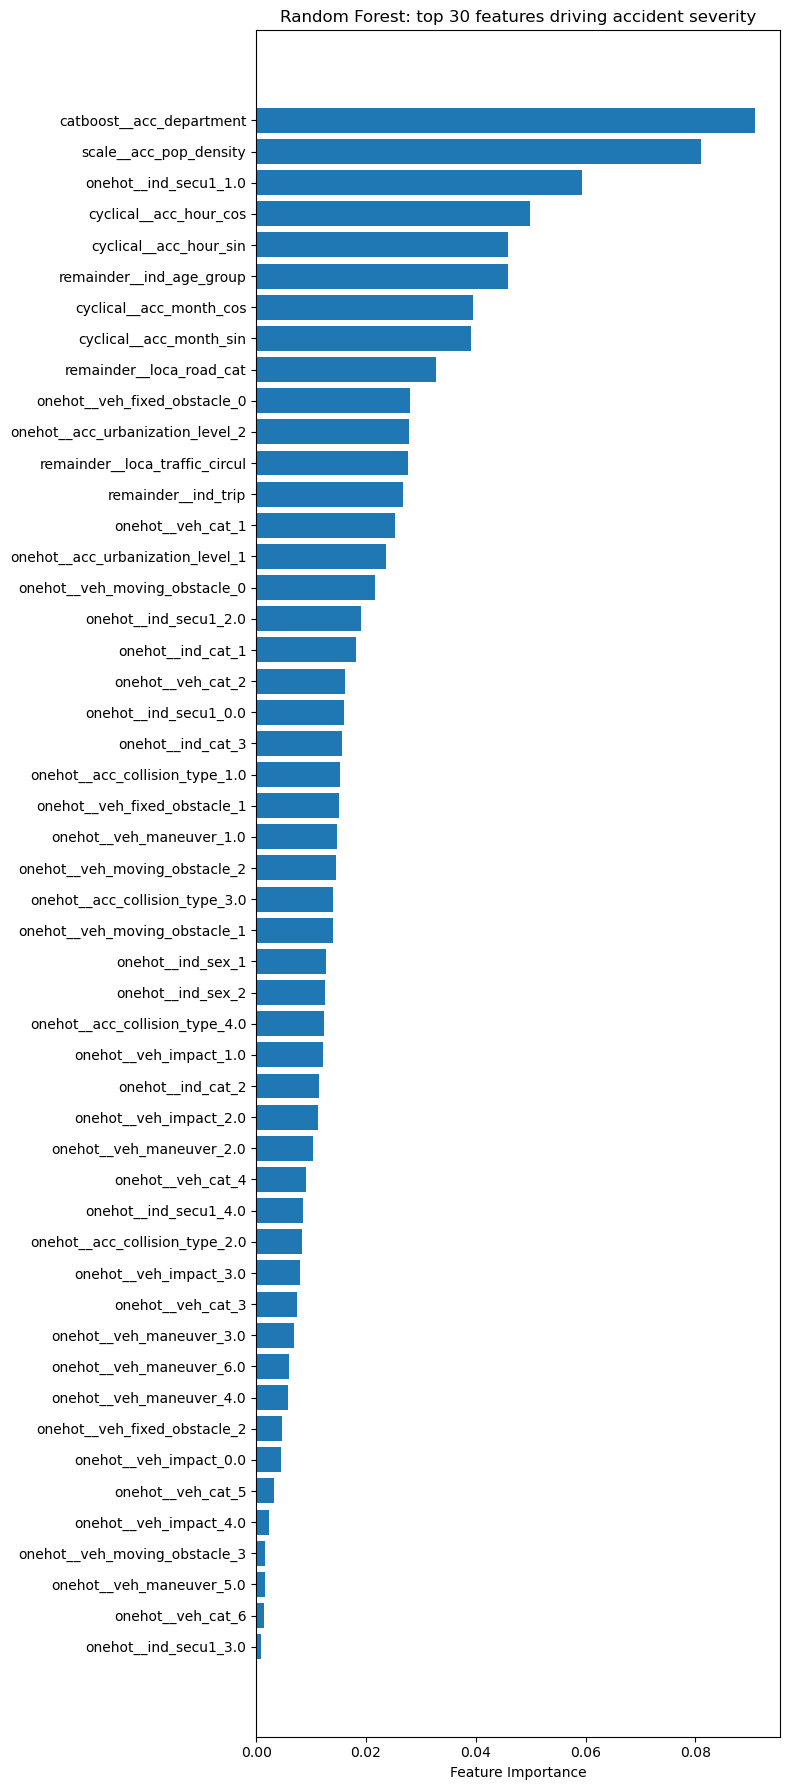

In [16]:
# --------------------------------------------------------------------------------------------------
# Evaluate performance
# --------------------------------------------------------------------------------------------------
print("✅ RandomForest Results")

# accuracy score to check if overfitted
print("Accuracy train:", accuracy_score(y_train, y_train_pred_best))
print("Accuracy test:", accuracy_score(y_test, y_test_pred_best))

# classifiction report
print("\nClassification Report:\n", classification_report(y_test, y_test_pred_best))

# confustion matrix
display(pd.crosstab(y_test, y_test_pred_best, rownames=["Actual"], colnames=["Predicted"]))
#print("\nConfusion Matrix:\n", confusion_matrix(y_test, y_pred))


# --------------------------------------------------------------------------------------------------
# Feature importance
# --------------------------------------------------------------------------------------------------
# pipline has np.array as output -> for feature_names a pd.DataFrame must be created to plot feature_importances_
feature_names = preprocessing_pipeline.named_steps["encode_scale"].get_feature_names_out()
#feature_names = preprocessing_pipeline.get_feature_names_out()
X_train_piped_df = pd.DataFrame(X_train_piped, columns=feature_names)

# Get feature importances from the trained RandomForest
importances = best_rf.feature_importances_
#feature_names = X_train_smote.columns

# Sort by importance
indices = np.argsort(importances)[::-1][:150]  # top 150

plt.figure(figsize=(8, 18))
plt.barh(range(len(indices)), importances[indices][::-1], align="center", height=0.8)
plt.yticks(range(len(indices)), feature_names[indices][::-1])
plt.xlabel("Feature Importance")
plt.title("Random Forest: top 30 features driving accident severity")
plt.tight_layout()
plt.show()

In [17]:
X_train_piped_df.info(max_cols=180)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 92600 entries, 0 to 92599
Data columns (total 50 columns):
 #   Column                            Non-Null Count  Dtype 
---  ------                            --------------  ----- 
 0   cyclical__acc_hour_sin            92600 non-null  object
 1   cyclical__acc_hour_cos            92600 non-null  object
 2   cyclical__acc_month_sin           92600 non-null  object
 3   cyclical__acc_month_cos           92600 non-null  object
 4   onehot__acc_urbanization_level_1  92600 non-null  object
 5   onehot__acc_urbanization_level_2  92600 non-null  object
 6   onehot__acc_collision_type_1.0    92600 non-null  object
 7   onehot__acc_collision_type_2.0    92600 non-null  object
 8   onehot__acc_collision_type_3.0    92600 non-null  object
 9   onehot__acc_collision_type_4.0    92600 non-null  object
 10  onehot__ind_cat_1                 92600 non-null  object
 11  onehot__ind_cat_2                 92600 non-null  object
 12  onehot__ind_cat_3 

In [13]:
# --------------------------------------------------------------------------------------------------
# print out all Feature importances in table
# --------------------------------------------------------------------------------------------------
feature_importances = pd.Series(importances, index=X_train_piped_df.columns).sort_values(ascending=False)
fi_df = feature_importances.to_frame(name="importance")
fi_df = fi_df.sort_values("importance", ascending=False)

pd.set_option("display.max_rows", None)   # show all rows
#print(feature_importances)
display(fi_table)
pd.reset_option("display.max_rows")


NameError: name 'fi_table' is not defined

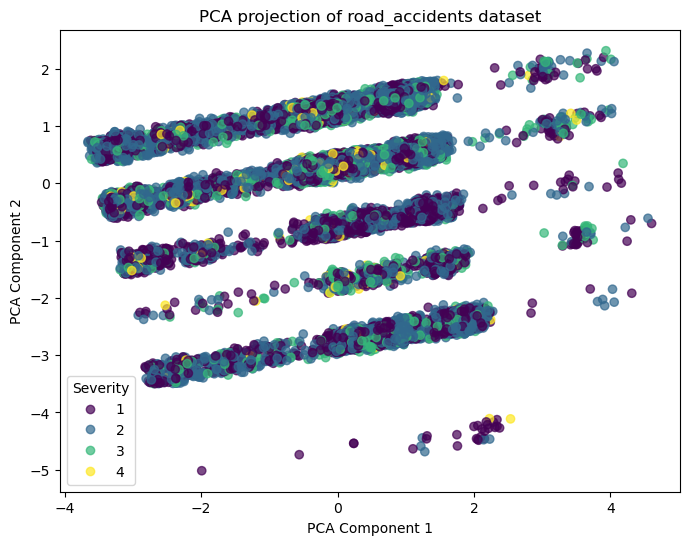

In [18]:
# PCA
pca = PCA(n_components=2, random_state=42)
X_test_pca = pca.fit_transform(X_test_piped)

# Plot with true labels
plt.figure(figsize=(8,6))
scatter = plt.scatter(X_test_pca[:,0], X_test_pca[:,1], c=y_test, cmap="viridis", alpha=0.7)
plt.xlabel("PCA Component 1")
plt.ylabel("PCA Component 2")
plt.title("PCA projection of road_accidents dataset")
plt.legend(*scatter.legend_elements(), title="Severity")
plt.show()



In [19]:
# --------------------------------------------------------------------------------------------------
# check propabilities for each individual and class
# --------------------------------------------------------------------------------------------------
proba_df = pd.DataFrame(
    y_test_proba,
    columns=[f"class_{c}" for c in best_rf.classes_]
)

proba_df.head()


,class_1,class_2,class_3,class_4
0,0.801165,0.167784,0.025729,0.005322
1,0.161105,0.174166,0.315459,0.349270
2,0.100713,0.376616,0.194428,0.328243
3,0.076202,0.364525,0.328642,0.230630
4,0.082842,0.771962,0.084445,0.060750


In [20]:
# --------------------------------------------------------------------------------------------------
# SHAP: import libraries
# --------------------------------------------------------------------------------------------------

import matplotlib.pyplot as plt
import seaborn as sns

import sys
sys.path.insert(1, '../../library')

import decoding_utils
import shap_values_aggr

import importlib
importlib.reload(decoding_utils)
importlib.reload(shap_values_aggr)

import shap


In [22]:
# --------------------------------------------------------------------------------------------------
# SHAP: create sample : 10000 records
# --------------------------------------------------------------------------------------------------

X_test_piped_df = pd.DataFrame(X_test_piped, columns=feature_names)

X_test_piped_df_float = X_test_piped_df.astype(float)
X_train_piped_df_float = X_train_piped_df.astype(float)

X_train_sample_df = X_train_piped_df_float.sample(10000)
X_train_sample_df.shape


(10000, 50)

In [24]:
# --------------------------------------------------------------------------------------------------
# SHAP: explainer, approximate=True
# --------------------------------------------------------------------------------------------------

shap_explainer_2 = shap.TreeExplainer(best_rf, X_train_sample_df)
shap_values_2 = shap_explainer_2(X_train_sample_df, approximate=True, check_additivity=False)


In [25]:
# --------------------------------------------------------------------------------------------------
# SHAP: aggregate
# --------------------------------------------------------------------------------------------------

import sys
import importlib
sys.path.insert(1, '../../library')

import decoding_utils
import shap_values_aggr

importlib.reload(decoding_utils)
importlib.reload(shap_values_aggr)

shap_values_r, df_new_shap_values, df_shap_data, columns_dict = shap_values_aggr.get_agg_shap_values_obj(shap_values_2, feature_names)

df_shap_data.head()


get_agg_shap_values: Processing items: 100%|██████████| 10000/10000 [00:00<00:00, 12629.73it/s]


,acc_hour,acc_month,acc_urbanization_level,acc_collision_type,ind_cat,ind_sex,ind_secu1,veh_cat,veh_fixed_obstacle,veh_moving_obstacle,veh_impact,veh_maneuver,acc_department,acc_pop_density,ind_trip,ind_age_group,loca_road_cat,loca_traffic_circul
0,18,5,2,3,1,1,2,2,0,2,1,4,1.588772,0.279006,5.0,3.0,2.0,2.0
1,10,10,2,2,2,2,4,4,0,2,1,1,1.815759,0.011690,5.0,4.0,5.0,3.0
2,4,1,2,2,1,1,1,1,0,2,1,1,1.599524,1.000000,5.0,4.0,5.0,1.0
3,20,3,1,1,1,1,1,1,0,2,1,1,1.718359,0.030151,5.0,4.0,4.0,2.0
4,20,0,1,4,1,2,1,1,0,2,1,1,1.870907,0.004335,1.0,2.0,4.0,2.0


In [144]:
# --------------------------------------------------------------------------------------------------
# SHAP: aggregate (single steps)
# --------------------------------------------------------------------------------------------------
'''
import copy

import sys
import importlib
sys.path.insert(1, '../../library')

import decoding_utils
import shap_values_aggr

importlib.reload(decoding_utils)
importlib.reload(shap_values_aggr)

columns_dict, _ = shap_values_aggr.create_features_dict(feature_names)

org_columns, encodings, encoded_lengths, prefixes, endings = shap_values_aggr.get_col_attributes(columns_dict)
col_bounderies = np.cumsum(encoded_lengths)

df_new_shap_values, new_shap_values_stacked_array, new_shap_values = shap_values_aggr.get_agg_shap_values(shap_values_2, org_columns, col_bounderies)

df_shap_data = shap_values_aggr.get_decoded_shap_data(shap_values_2, col_bounderies, encoded_lengths, encodings, org_columns, prefixes, endings)

shap_values_r = copy.deepcopy(shap_values_2)

shap_values_r.values = new_shap_values_stacked_array
shap_values_r.data = np.array(np.array(df_shap_data))
shap_values_r.feature_names = list(df_shap_data.columns)

df_shap_data
'''

In [26]:
shap_values_r.data.shape #(10000, 18)

(10000, 18)

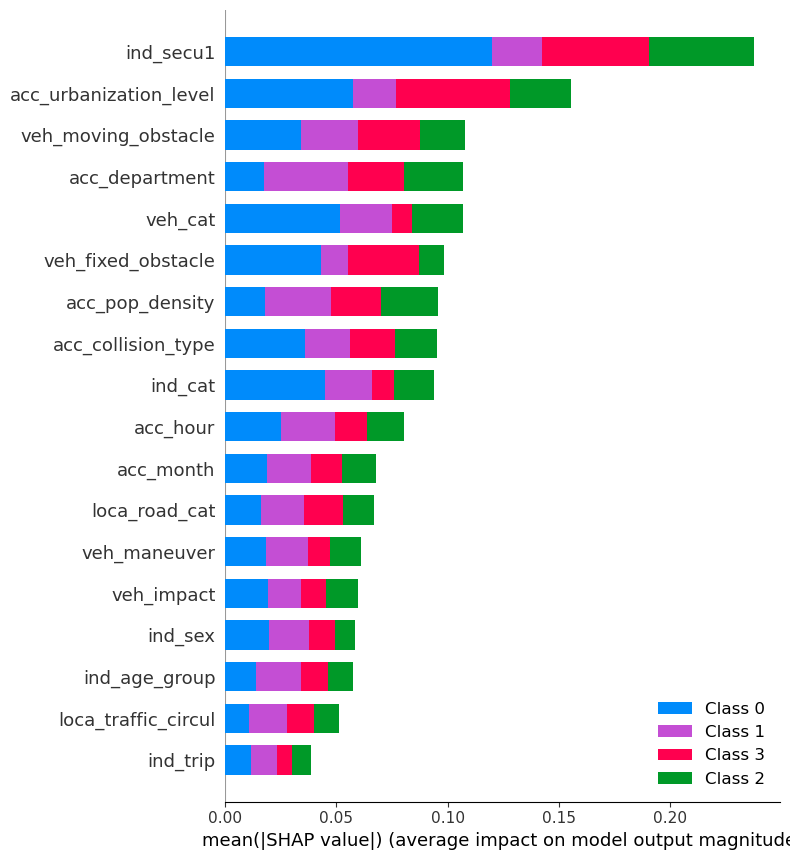

In [27]:
# ----------------------------------------------
# SHAP: create aggregated summary_plot
# 
# ----------------------------------------------

shap.summary_plot(shap_values_r, shap_values_r.data, plot_type="bar", max_display=30)


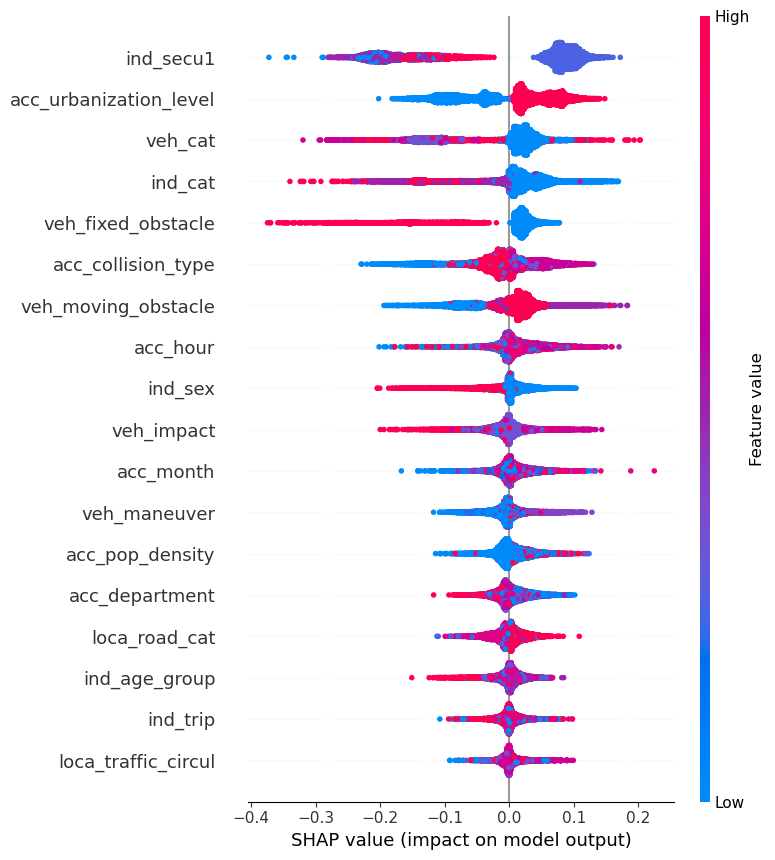

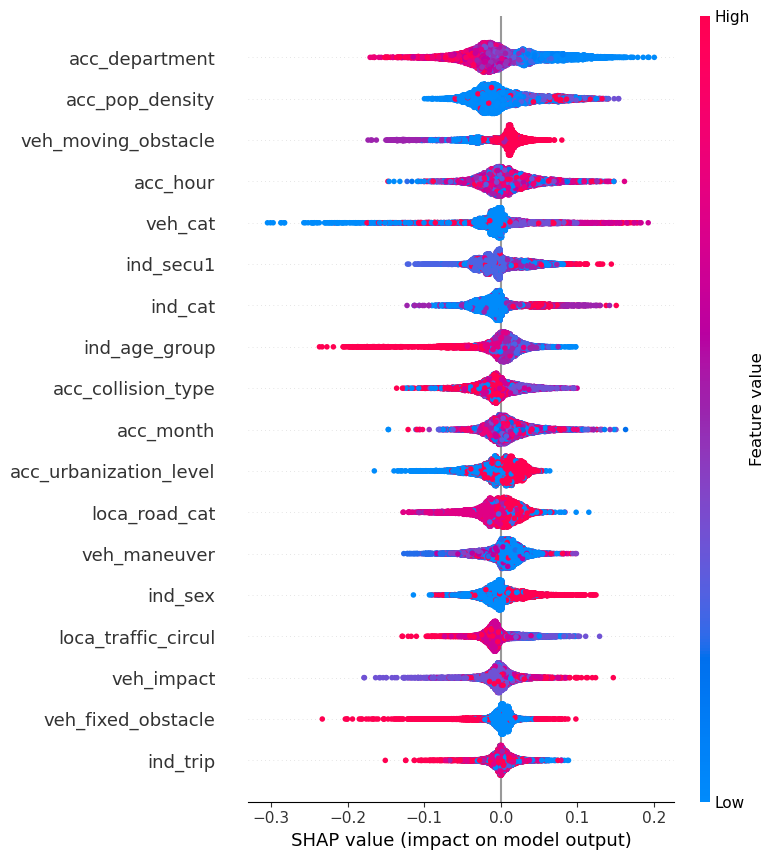

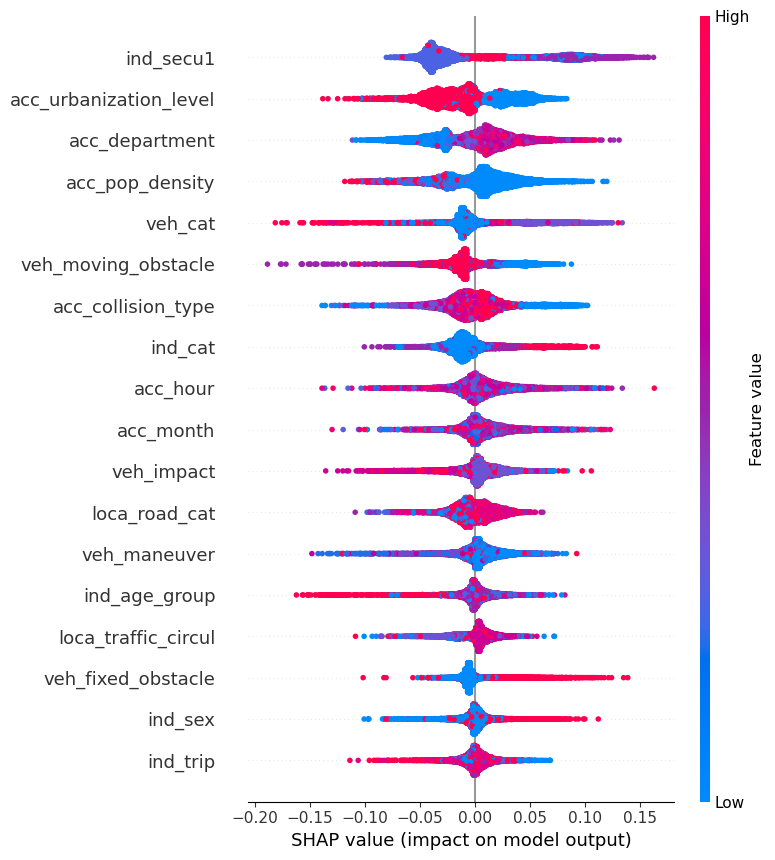

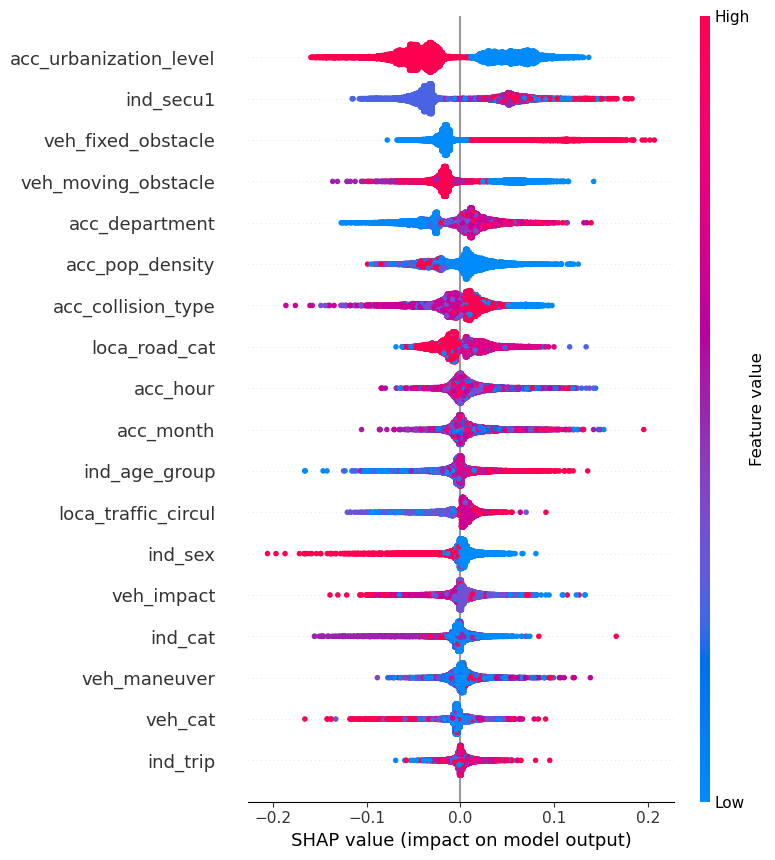

In [28]:
# -------------------------------------------------------------------------------------------------
# Shap: aggregated summary plot, class 0-3
# -------------------------------------------------------------------------------------------------

for i in range(4):
    class_id = i
    shap.summary_plot(shap_values_r[:, :, class_id], shap_values_r.data)


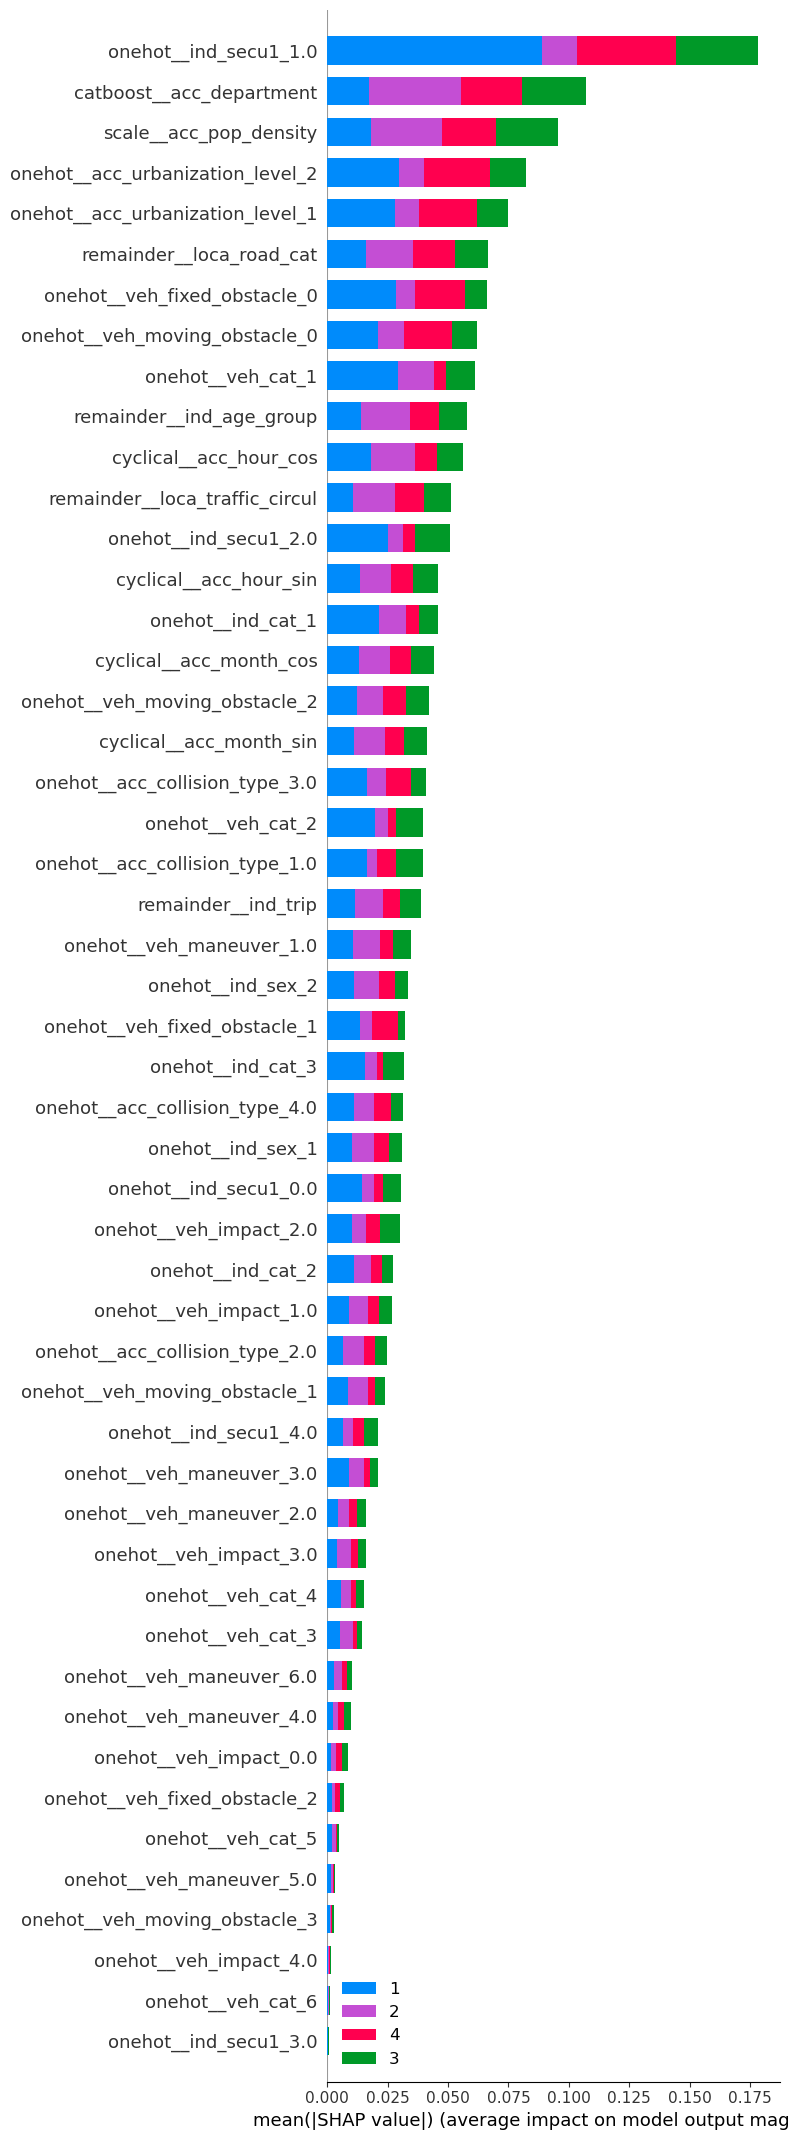

In [29]:
# ----------------------------------------------
# Shap: summary plot
# ----------------------------------------------
shap.summary_plot(shap_values_2, X_train_sample_df, plot_type="bar", class_names=best_rf.classes_ , title="", max_display=50)


Summary plot for class 0


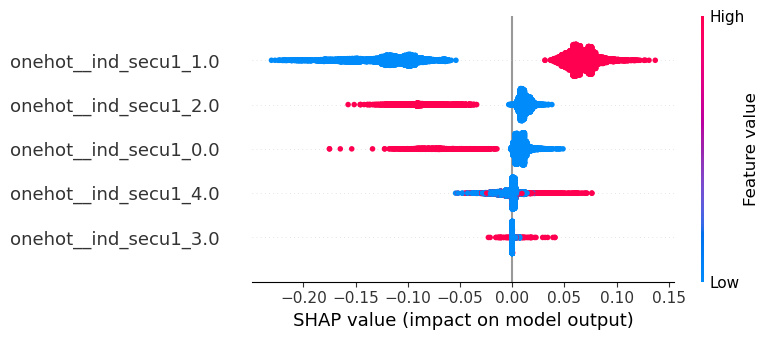

Summary plot for class 1


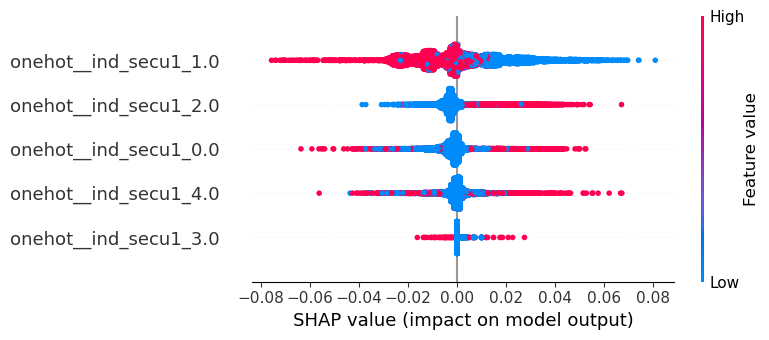

Summary plot for class 2


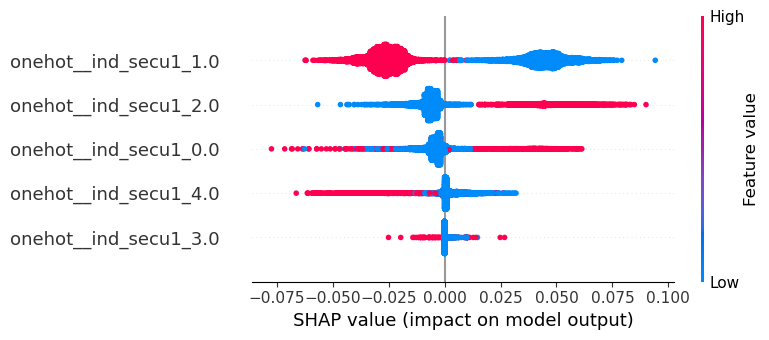

Summary plot for class 3


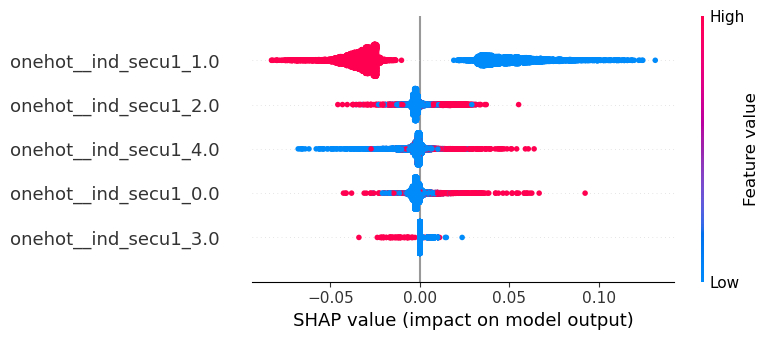

In [36]:
# NEW summary_plot looped over all classes with subset of features
#--------------------------------------------------------------

# Get all feature names
all_features = shap_values_2.feature_names

# Filter names that start with the prefix
prefix = "onehot__ind_secu1_"
#prefix = "onehot__acc_collision_type_"
selected_features = [f for f in all_features if f.startswith(prefix)]

# Get indices of the selected features
selected_idx = [all_features.index(f) for f in selected_features]

# Slice SHAP values for class 0 and only those features
#shap_subset = shap_values_2.values[:, selected_idx, 0]
#X_subset = X_train_sample_df[selected_features]
#shap.summary_plot(
#    shap_subset,
#    features=X_subset,
#    feature_names=selected_features
#)

for c in range(shap_values_2.values.shape[-1]):  # iterate over classes
    shap_subset = shap_values_2.values[:, selected_idx, c]
    X_subset = X_train_sample_df[selected_features]
    print(f"Summary plot for class {c}")
    shap.summary_plot(
        shap_subset,
        features=X_subset,
        feature_names=selected_features,
        max_display=len(selected_features)
    )


In [35]:
# --------------------------------------------------------------------------------------------------
# dump: df (2023, incl population density)
# --------------------------------------------------------------------------------------------------

dump(df, "../../data/processed/2_preprocessing/1.0-simmler_df_2023_pop_density.joblib")

#dump(best_rf, "../../models/model_rf_over_under_2023_pop_density.joblib", compress=3)
#dump(preprocessing_pipeline, "../../models/pipeline_rf_over_under_2023_pop_density.pkl", compress=3)


['../../data/processed/2_preprocessing/1.0-simmler_df_2023_pop_density.joblib']

In [31]:
# --------------------------------------------------------------------------------------------------

In [14]:
# --------------------------------------------------------------------------------------------------
# safe fitted model
# --------------------------------------------------------------------------------------------------
dump(best_rf, "../../models/model_rf_over_under_2019_2024.joblib", compress=3)


['../../models/model_rf_over_under_2019_2024.joblib']

In [13]:
# --------------------------------------------------------------------------------------------------
# safe fitted pipeline
# --------------------------------------------------------------------------------------------------
dump(preprocessing_pipeline, "../../models//pipeline_rf_over_under_2019_2024.pkl", compress=3)


['../../models//pipeline_rf_over_under_2019_2024.pkl']

In [15]:
# --------------------------------------------------------------------------------------------------
# stratified sample for SHAP values 
# --------------------------------------------------------------------------------------------------
# stratified sample for model explaining
X_sub, _, y_sub, _ = train_test_split(X, y, train_size=30000, stratify=y, random_state=42)

# transform sample the EXACT same way like the fitted model -> very important, otherwise SHAP values do not work
X_sub_clean = preprocessing_pipeline.transform(X_sub)
X_sub_clean = np.array(X_sub_clean, dtype=np.float64)



ℹ️ RemoveIrrelevantCols -> The following columns were not found and skipped: ['ind_triploca_road_cat', 'ind_age_grouploca_traffic_circul']
ℹ️ RemoveIdCols -> The following columns were not found and skipped: ['ind_temp_id']


In [16]:
# -------------------------------------------------------------------------------------------------------------
# SHAP value computation
# -------------------------------------------------------------------------------------------------------------

# store feature_names from pipeline
feature_names = preprocessing_pipeline.named_steps["encode_scale"].get_feature_names_out()

# make a list out of features for later use of indices (f.e. for aggregation)
all_features = list(feature_names)

# df für spätere leichtere Auswertungen
X_sub_df = pd.DataFrame(X_sub_clean, columns=feature_names)

# Explainer object of new SHAP api with np.array of pipeline as input
explainer_new = shap.Explainer(best_rf, X_sub_clean)

# Shap value computation aslo with np.array as inut -> important!! must be the same input like in model and Explainer
#shap_values_new = explainer_new(X_sub_clean, check_additivity=False)
shap_values_new = explainer_new(X_sub_clean, check_additivity=False, approximate=True)

# add feature names to shap_values from pipeline seperatly because input was np.array wihtout features names
shap_values_new.feature_names = feature_names


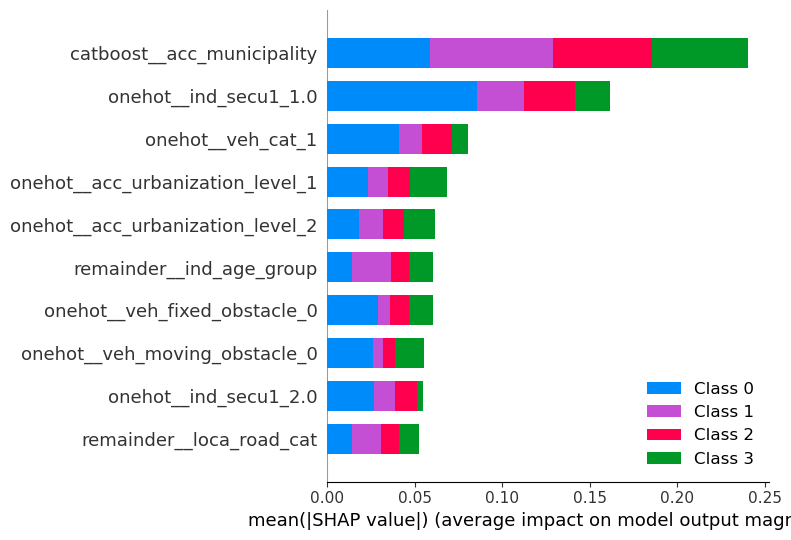

In [17]:
# NEW summary_plot on all classes
#--------------------------------------------------------------
shap.summary_plot(shap_values_new.values[:, :, :], features=X_sub_clean, feature_names=feature_names, plot_type= 'bar', max_display=10)


In [18]:
class ShapOneHotAggregator:
    """
    Aggregate SHAP values of one-hot and cyclical encoded features back to their original feature.
    """

    def __init__(self, feature_names, prefix="onehot__", cyclical_prefix="cyclical__"):
        self.feature_names = feature_names
        self.prefix = prefix
        self.cyclical_prefix = cyclical_prefix
        self.groups = self._build_groups()

    def _build_groups(self):
        groups = {}
        for fname in self.feature_names:
            if fname.startswith(self.prefix):
                # One-hot encoded
                base = fname[len(self.prefix):]
                parent = base.rsplit("_", 1)[0]
                groups.setdefault(parent, []).append(fname)
            elif fname.startswith(self.cyclical_prefix):
                # Cyclical encoded (_sin/_cos)
                parent = fname.rsplit("_", 1)[0]  # remove _sin/_cos
                groups.setdefault(parent, []).append(fname)
            else:
                # Continuous or already atomic
                groups.setdefault(fname, [fname])
        return groups

    def aggregate(self, shap_values, data, base_values=None):
        has_classes = shap_values.ndim == 3
        agg_list, agg_feature_names = [], []

        for parent, children in self.groups.items():
            idxs = [self.feature_names.index(ch) for ch in children]
            if has_classes:
                agg_vals = shap_values[:, idxs, :].sum(axis=1)
            else:
                agg_vals = shap_values[:, idxs].sum(axis=1)
            agg_list.append(agg_vals)
            agg_feature_names.append(parent)

        agg_values = np.stack(agg_list, axis=1) if has_classes else np.column_stack(agg_list)

        # Collapse data
        X_df = pd.DataFrame(data, columns=self.feature_names)
        agg_data = pd.DataFrame(index=X_df.index)
        for parent, children in self.groups.items():
            if parent.startswith("cyclical__") and len(children) == 2:
                # Keep both sin/cos values but collapse into one parent vector
                agg_data[parent] = np.sqrt(X_df[children[0]]**2 + X_df[children[1]]**2)
            elif len(children) > 1 and children[0].startswith(self.prefix):
                # One-hot collapse
                agg_data[parent] = X_df[children].idxmax(axis=1).str.replace(f"{parent}_", "")
            else:
                agg_data[parent] = X_df[children[0]]

        explainer_agg = shap.Explanation(
            values=agg_values,
            base_values=base_values,
            data=agg_data.values,
            feature_names=agg_feature_names
        )
        return explainer_agg, self.groups

In [19]:
# --------------------------------------------------------------------------------------------------
# SHAP value aggregation
# --------------------------------------------------------------------------------------------------
aggregator = ShapOneHotAggregator(all_features)
explainer_agg, mapping = aggregator.aggregate(shap_values_new.values, shap_values_new.data)

# Now explainer_agg.values and explainer_agg.data have matching shapes
print(explainer_agg.values.shape)  # (n_samples, n_features_new, n_classes)
print(explainer_agg.data.shape)    # (n_samples, n_features_new)



(30000, 17, 4)
(30000, 17)


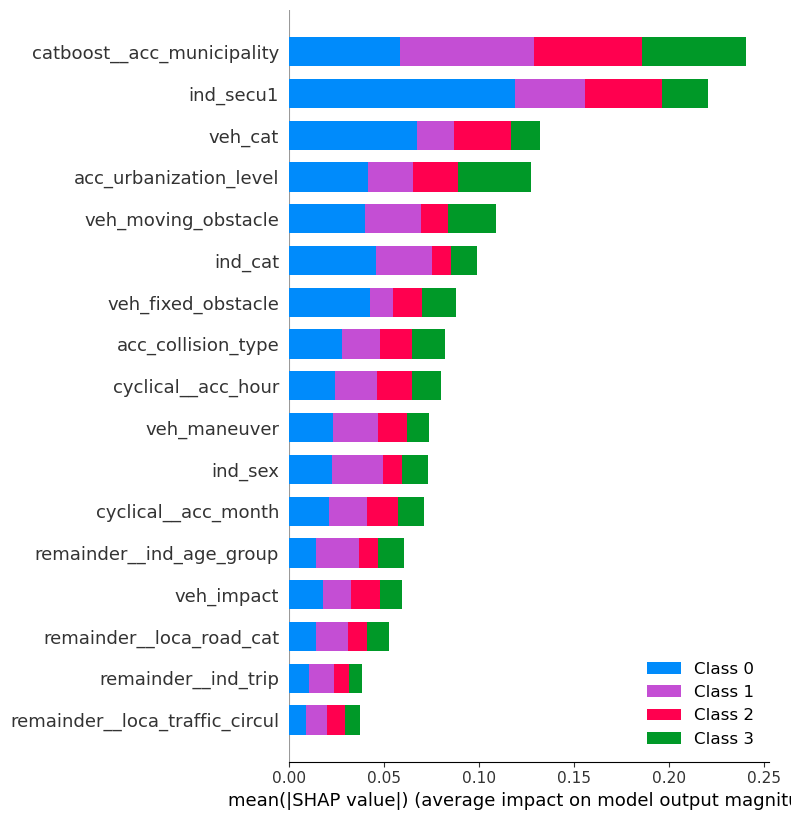

In [20]:
# plot aggregated features
shap.summary_plot(
    explainer_agg.values,
    explainer_agg.data,
    feature_names=explainer_agg.feature_names,
    plot_type="bar",
    max_display=32
)